# Rice Classification

In [1]:
# Import all libraries
import numpy as np
import sys
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict,train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
print(sklearn.__version__)
print(sys.version)

1.6.1
3.9.23 (main, Jun  5 2025, 13:25:08) [MSC v.1929 64 bit (AMD64)]


In [3]:
# Ignore future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Load the rice dataset: rice-final2.csv
rice_data = pd.read_csv('rice-final2.csv', na_values='?')
rice_data.head()

,Area,Perimiter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,class
0,12573.0,461.466003,192.903351,84.572075,0.898772,12893.0,0.550433,class2
1,12845.0,464.121002,194.332214,85.524338,0.897952,13125.0,0.774962,class2
2,14055.0,488.748993,207.751755,87.250328,0.907536,14484.0,0.550076,class1
3,14412.0,490.324005,207.476135,89.689514,0.901735,14703.0,0.598853,class1
4,14658.0,477.117004,189.566635,99.997780,0.849551,15048.0,0.649504,class2


In [5]:
# Pre-process dataset
## Split into features (X) and labels (y)
X_raw = rice_data.iloc[:, :-1].values  # all columns except last
y_raw = rice_data.iloc[:, -1].values   # last column is class

## 1) Replace missing values with column mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_raw)

## 2) Normalize features to [0,1] using Min-Max scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X_imputed)

## 3) Map class labels: class1 -> 0, class2 -> 1
y = np.where(y_raw == 'class1', 0, np.where(y_raw == 'class2', 1, y_raw))
y = y.astype(int)

In [6]:
# Print first ten rows of pre-processed dataset to 4 decimal places as per assignment spec
# A function is provided to assist

def print_data(X, y, n_rows=10):
    """Takes a numpy data array and target and prints the first ten rows.
    
    Arguments:
        X: numpy array of shape (n_examples, n_features)
        y: numpy array of shape (n_examples)
        n_rows: numpy of rows to print
    """
    for example_num in range(n_rows):
        for feature in X[example_num]:
            print("{:.4f}".format(feature), end=",")

        if example_num == len(X)-1:
            print(y[example_num],end="")
        else:
            print(y[example_num])
            
print_data(X,y)

0.4628,0.5406,0.5113,0.4803,0.7380,0.4699,0.1196,1
0.4900,0.5547,0.5266,0.5018,0.7319,0.4926,0.8030,1
0.6109,0.6847,0.6707,0.5409,0.8032,0.6253,0.1185,0
0.6466,0.6930,0.6677,0.5961,0.7601,0.6467,0.2669,0
0.6712,0.6233,0.4755,0.8293,0.3721,0.6803,0.4211,1
0.2634,0.2932,0.2414,0.4127,0.5521,0.2752,0.2825,1
0.8175,0.9501,0.9515,0.5925,0.9245,0.8162,0.0000,0
0.3174,0.3588,0.3601,0.3908,0.6921,0.3261,0.8510,1
0.3130,0.3050,0.2150,0.5189,0.3974,0.3159,0.4570,1
0.5120,0.5237,0.4409,0.6235,0.5460,0.5111,0.3155,1


### Part 1: Cross-validation without parameter tuning

In [7]:
## Setting the 10 fold stratified cross-validation
cvKFold=StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# The stratified folds from cvKFold should be provided to the classifiers

In [8]:
# Logistic Regression
def logregClassifier(X, y):
    clf = LogisticRegression(random_state=0)
    scores = cross_val_score(clf, X, y, cv=cvKFold)
    return scores.mean()

In [9]:
#Naïve Bayes
def nbClassifier(X, y):
    clf = GaussianNB()
    scores = cross_val_score(clf, X, y, cv=cvKFold)
    return scores.mean()

In [10]:
# Decision Tree
def dtClassifier(X, y):
    clf = DecisionTreeClassifier(criterion='entropy', random_state=0)
    scores = cross_val_score(clf, X, y, cv=cvKFold)
    return scores.mean()

In [11]:
# Ensembles: Bagging, Ada Boost and Gradient Boosting
def bagDTClassifier(X, y, n_estimators, max_samples, max_depth):
    base = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=0)
    clf = BaggingClassifier(estimator=base, n_estimators=n_estimators,
                            max_samples=max_samples, random_state=0)
    scores = cross_val_score(clf, X, y, cv=cvKFold)
    return scores.mean()

def adaDTClassifier(X, y, n_estimators, learning_rate, max_depth):
    base = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=0)
    clf = AdaBoostClassifier(estimator=base, n_estimators=n_estimators,
                             learning_rate=learning_rate, random_state=0)
    scores = cross_val_score(clf, X, y, cv=cvKFold)
    return scores.mean()

def gbClassifier(X, y, n_estimators, learning_rate):
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=0)
    scores = cross_val_score(clf, X, y, cv=cvKFold)
    return scores.mean()

### Part 1 Results

In [12]:
# Parameters for Part 1:

#Bagging
bag_n_estimators = 50
bag_max_samples = 100
bag_max_depth = 5

#AdaBoost
ada_n_estimators = 50
ada_learning_rate = 0.5
ada_bag_max_depth = 5

#GB
gb_n_estimators = 50
gb_learning_rate = 0.5

# Call each classifier function and store the results
logr_acc = logregClassifier(X, y)
nb_acc = nbClassifier(X, y)
dt_acc = dtClassifier(X, y)
bag_acc = bagDTClassifier(X, y, bag_n_estimators, bag_max_samples, bag_max_depth)
ada_acc = adaDTClassifier(X, y, ada_n_estimators, ada_learning_rate, ada_bag_max_depth)
gb_acc = gbClassifier(X, y, gb_n_estimators, gb_learning_rate)

# Print results for each classifier in part 1 to 4 decimal places here:
'''
print("LogR average cross-validation accuracy: ")
print("NB average cross-validation accuracy: ")
print("DT average cross-validation accuracy: ")
print("Bagging average cross-validation accuracy: ")
print("AdaBoost average cross-validation accuracy: ")
print("GB average cross-validation accuracy: ")
'''

# using f-string
print(f"LogR average cross-validation accuracy: {logr_acc:.4f}")
print(f"NB average cross-validation accuracy: {nb_acc:.4f}")
print(f"DT average cross-validation accuracy: {dt_acc:.4f}")
print(f"Bagging average cross-validation accuracy: {bag_acc:.4f}")
print(f"AdaBoost average cross-validation accuracy: {ada_acc:.4f}")
print(f"GB average cross-validation accuracy: {gb_acc:.4f}")

LogR average cross-validation accuracy: 0.9386
NB average cross-validation accuracy: 0.9264
DT average cross-validation accuracy: 0.9179
Bagging average cross-validation accuracy: 0.9414
AdaBoost average cross-validation accuracy: 0.9407
GB average cross-validation accuracy: 0.9321


### Results Visualization

In [13]:
def evaluate_metrics(cm):
    #Calculate Accuracy, Precision, Recall, F1 from confusion matrix
    TN, FP, FN, TP = cm.ravel()

    acc = (TP + TN) / (TP + TN + FP + FN)
    prec = TP / (TP + FP) if (TP + FP) > 0 else 0
    rec = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

    return acc, prec, rec, f1

# All images in this experiment will be saved in this 'png' folder
os.makedirs("png", exist_ok=True)

#### Logistic Regression

Image saved.


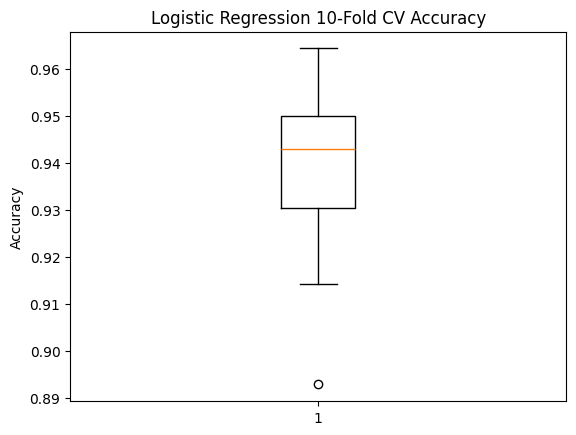

In [14]:
# Boxplot
def logreg_Scores(X, y):
    clf = LogisticRegression(random_state=0)
    # Accuracy per fold
    scores = cross_val_score(clf, X, y, cv=cvKFold)
    return scores  

logr_scores = logreg_Scores(X, y)

plt.boxplot(logr_scores)
plt.title("Logistic Regression 10-Fold CV Accuracy")
plt.ylabel("Accuracy")

# Save png
plt.savefig("png/logreg_boxplot.png", dpi=300, bbox_inches="tight")
print("Image saved.")

plt.show()

Image saved.


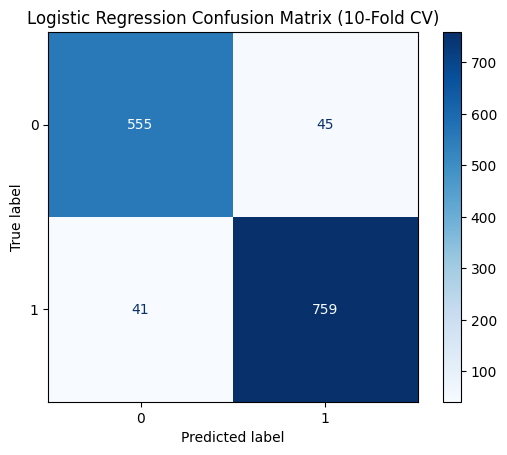

[[555  45]
 [ 41 759]]


In [15]:
# Confusion Matrix
def logregConfusionMatrix(X, y):
    clf = LogisticRegression(random_state=0)
    # Get the cross-validation prediction results for each sample
    y_pred = cross_val_predict(clf, X, y, cv=cvKFold)
    
    # calculate confusion matrix
    cm = confusion_matrix(y, y_pred)
    
    # Display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Logistic Regression Confusion Matrix (10-Fold CV)")
    
    # Save png
    plt.savefig("png/logreg_confusion_matrix.png", dpi=300, bbox_inches="tight")
    print("Image saved.")
    plt.show()
    
    return cm

logreg_cm = logregConfusionMatrix(X, y)
print(logreg_cm)

In [16]:
# Accuracy,Precision,Recall,F1
acc, prec, rec, f1 = evaluate_metrics(logreg_cm)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")

Accuracy: 0.9386
Precision: 0.9440
Recall: 0.9487
F1: 0.9464


#### Naïve Bayes

Image saved.


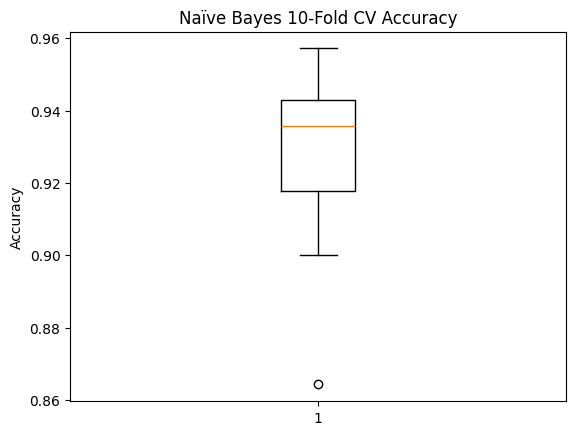

In [17]:
# Boxplot
def nb_Scores(X, y):
    clf = GaussianNB() 
    scores = cross_val_score(clf, X, y, cv=cvKFold)
    return scores  

nb_scores = nb_Scores(X, y)

plt.boxplot(nb_scores)
plt.title("Naïve Bayes 10-Fold CV Accuracy")
plt.ylabel("Accuracy")

# Save png
plt.savefig("png/naive_bayes_boxplot.png", dpi=300, bbox_inches="tight")
print("Image saved.")

plt.show()

Image saved.


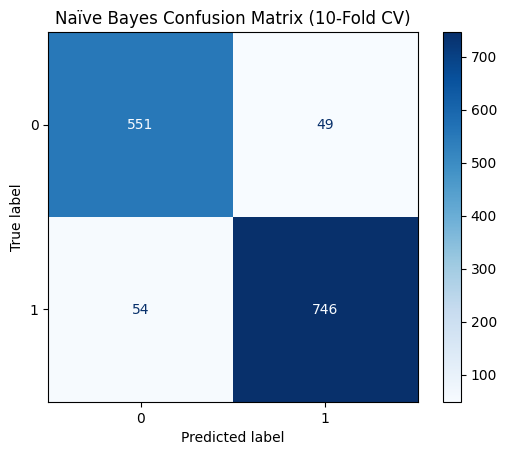

[[551  49]
 [ 54 746]]


In [18]:
# Confusion Matrix
def nbConfusionMatrix(X, y):
    clf = GaussianNB()
    # Get the cross-validation prediction results for each sample
    y_pred = cross_val_predict(clf, X, y, cv=cvKFold)
    
    # calculate confusion matrix
    cm = confusion_matrix(y, y_pred)
    
    # Display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Naïve Bayes Confusion Matrix (10-Fold CV)")
    
    # Save png
    plt.savefig("png/naive_bayes_confusion_matrix.png", dpi=300, bbox_inches="tight")
    print("Image saved.")
    plt.show()
    
    return cm

# Run and print confusion matrix
nb_cm = nbConfusionMatrix(X, y)
print(nb_cm)

In [19]:
acc, prec, rec, f1 = evaluate_metrics(nb_cm)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")

Accuracy: 0.9264
Precision: 0.9384
Recall: 0.9325
F1: 0.9354


#### Decision Tree

Image saved.


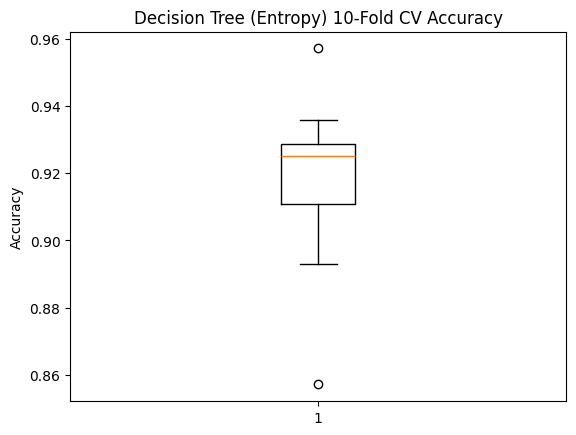

In [20]:
# Boxplot
def dt_Scores(X, y):
    clf = DecisionTreeClassifier(criterion="entropy", random_state=0)
    scores = cross_val_score(clf, X, y, cv=cvKFold)  # 10-fold stratified CV
    return scores

dt_scores = dt_Scores(X, y)

plt.boxplot(dt_scores)
plt.title("Decision Tree (Entropy) 10-Fold CV Accuracy")
plt.ylabel("Accuracy")

plt.savefig("png/dt_boxplot.png", dpi=500, bbox_inches="tight")
print("Image saved.")

plt.show()

Image saved.


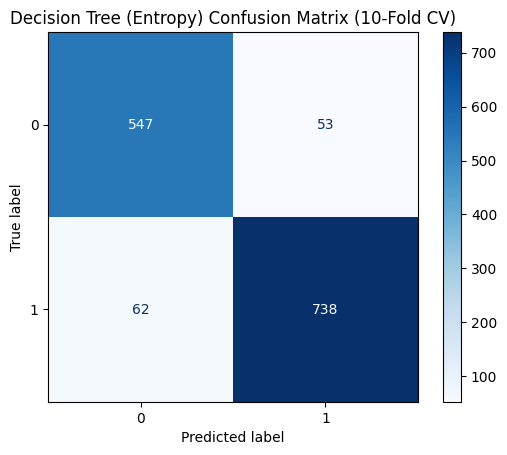

[[547  53]
 [ 62 738]]


In [21]:
# Confusion matrix
def dtConfusionMatrix(X, y):
    clf = DecisionTreeClassifier(criterion="entropy", random_state=0)
    y_pred = cross_val_predict(clf, X, y, cv=cvKFold) 
    cm = confusion_matrix(y, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Decision Tree (Entropy) Confusion Matrix (10-Fold CV)")

    plt.savefig("png/dt_confusion_matrix.png", dpi=300, bbox_inches="tight")
    print("Image saved.")
    plt.show()
    
    return cm

dt_cm = dtConfusionMatrix(X, y)
print(dt_cm)

In [22]:
acc, prec, rec, f1 = evaluate_metrics(dt_cm)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1:        {f1:.4f}")

Accuracy:  0.9179
Precision: 0.9330
Recall:    0.9225
F1:        0.9277


#### Bagging

Image saved.


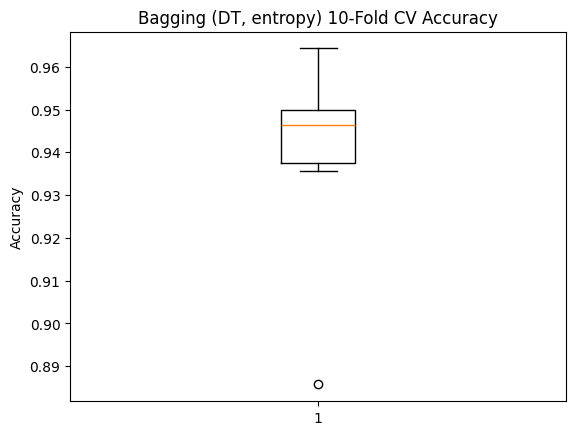

In [23]:
# Boxplot
def bag_Scores(X, y):
    base = DecisionTreeClassifier(criterion="entropy", max_depth=bag_max_depth, random_state=0)
    clf = BaggingClassifier(estimator=base,
                            n_estimators=bag_n_estimators,
                            max_samples=bag_max_samples,
                            random_state=0)
    scores = cross_val_score(clf, X, y, cv=cvKFold)
    return scores

bag_scores = bag_Scores(X, y)

plt.boxplot(bag_scores)
plt.title("Bagging (DT, entropy) 10-Fold CV Accuracy")
plt.ylabel("Accuracy")

plt.savefig("png/bagging_boxplot.png", dpi=500, bbox_inches="tight")
print("Image saved.")

plt.show()

Image saved.


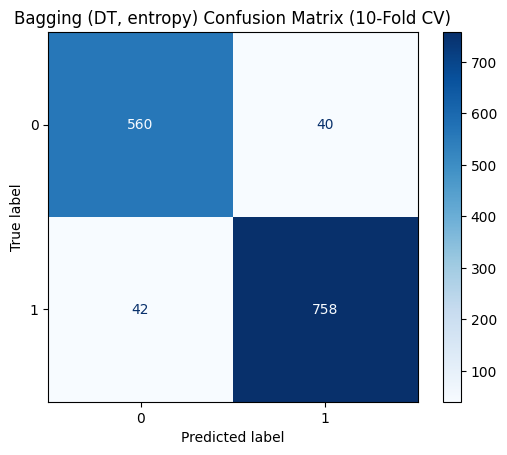

[[560  40]
 [ 42 758]]


In [24]:
# Confusion Matrix
def bagConfusionMatrix(X, y):
    base = DecisionTreeClassifier(criterion="entropy", max_depth=bag_max_depth, random_state=0)
    clf = BaggingClassifier(estimator=base,
                            n_estimators=bag_n_estimators,
                            max_samples=bag_max_samples,
                            random_state=0)
    y_pred = cross_val_predict(clf, X, y, cv=cvKFold)
    cm = confusion_matrix(y, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Bagging (DT, entropy) Confusion Matrix (10-Fold CV)")
    
    plt.savefig("png/bagging_confusion_matrix.png", dpi=300, bbox_inches="tight")
    print("Image saved.")
    plt.show()
    return cm

bag_cm = bagConfusionMatrix(X, y)
print(bag_cm)

In [25]:
acc, prec, rec, f1 = evaluate_metrics(bag_cm)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1:        {f1:.4f}")

Accuracy:  0.9414
Precision: 0.9499
Recall:    0.9475
F1:        0.9487


#### AdaBoost

Image saved.


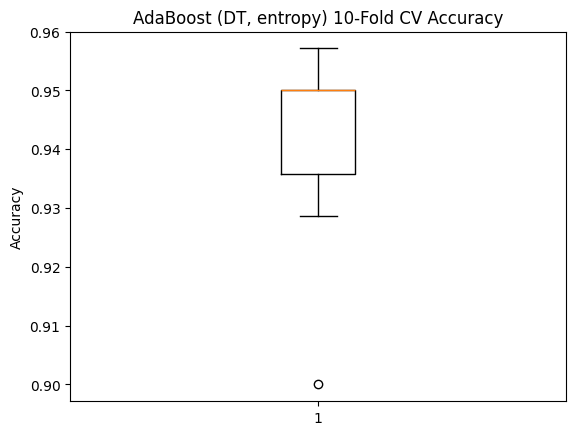

In [26]:
# Boxplot
def ada_Scores(X, y):
    base = DecisionTreeClassifier(criterion="entropy", max_depth=ada_bag_max_depth, random_state=0)
    clf = AdaBoostClassifier(estimator=base,
                             n_estimators=ada_n_estimators,
                             learning_rate=ada_learning_rate,
                             random_state=0)
    scores = cross_val_score(clf, X, y, cv=cvKFold)
    return scores

ada_scores = ada_Scores(X, y)

plt.boxplot(ada_scores)
plt.title("AdaBoost (DT, entropy) 10-Fold CV Accuracy")
plt.ylabel("Accuracy")

plt.savefig("png/adaboost_boxplot.png", dpi=500, bbox_inches="tight")
print("Image saved.")
plt.show()

Image saved.


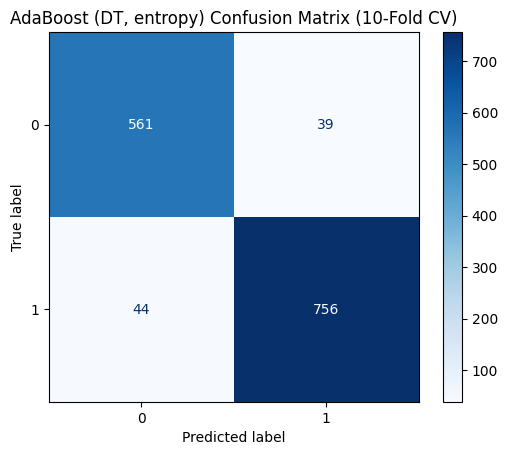

[[561  39]
 [ 44 756]]


In [27]:
# Confusion Matrix
def adaConfusionMatrix(X, y):
    base = DecisionTreeClassifier(criterion="entropy", max_depth=ada_bag_max_depth, random_state=0)
    clf = AdaBoostClassifier(estimator=base,
                             n_estimators=ada_n_estimators,
                             learning_rate=ada_learning_rate,
                             random_state=0)
    y_pred = cross_val_predict(clf, X, y, cv=cvKFold)
    cm = confusion_matrix(y, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("AdaBoost (DT, entropy) Confusion Matrix (10-Fold CV)")

    plt.savefig("png/adaboost_confusion_matrix.png", dpi=300, bbox_inches="tight")
    print("Image saved.")
    plt.show()
    
    return cm

ada_cm = adaConfusionMatrix(X, y)
print(ada_cm)

In [28]:
acc, prec, rec, f1 = evaluate_metrics(ada_cm)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1:        {f1:.4f}")

Accuracy:  0.9407
Precision: 0.9509
Recall:    0.9450
F1:        0.9480


#### Gradient Boosting

Image saved.


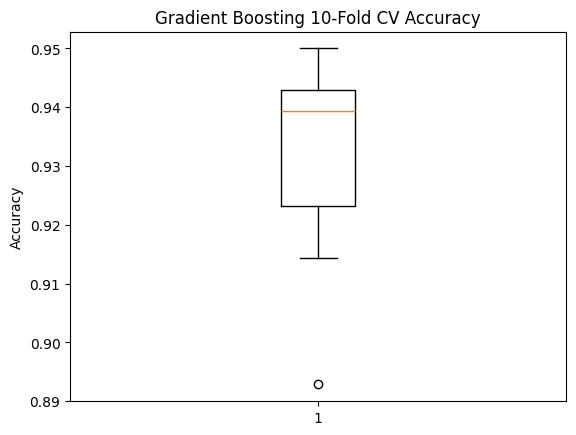

In [29]:
# Boxplot
def gb_Scores(X, y):
    clf = GradientBoostingClassifier(n_estimators=gb_n_estimators,
                                     learning_rate=gb_learning_rate,
                                     random_state=0)
    scores = cross_val_score(clf, X, y, cv=cvKFold)
    return scores

gb_scores = gb_Scores(X, y)

plt.boxplot(gb_scores)
plt.title("Gradient Boosting 10-Fold CV Accuracy")
plt.ylabel("Accuracy")

plt.savefig("png/gb_boxplot.png", dpi=500, bbox_inches="tight")
print("Image saved.")
plt.show()

Image saved.


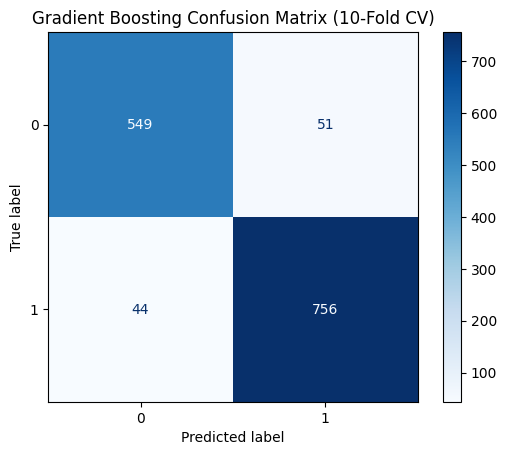

[[549  51]
 [ 44 756]]


In [30]:
# Confusion Matrix
def gbConfusionMatrix(X, y):
    clf = GradientBoostingClassifier(n_estimators=gb_n_estimators,
                                     learning_rate=gb_learning_rate,
                                     random_state=0)
    y_pred = cross_val_predict(clf, X, y, cv=cvKFold)
    cm = confusion_matrix(y, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Gradient Boosting Confusion Matrix (10-Fold CV)")

    plt.savefig("png/gb_confusion_matrix.png", dpi=300, bbox_inches="tight")
    print("Image saved.")
    plt.show()
    
    return cm

gb_cm = gbConfusionMatrix(X, y)
print(gb_cm)

In [31]:
acc, prec, rec, f1 = evaluate_metrics(gb_cm)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1:        {f1:.4f}")

Accuracy:  0.9321
Precision: 0.9368
Recall:    0.9450
F1:        0.9409


### Part 2: Cross-validation with parameter tuning

In [32]:
# KNN
k = [1, 3, 5, 7]
p = [1, 2]


def bestKNNClassifier(X, y):
    # Split data into training and test sets with stratification and fixed random state
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

    # Define parameter grid for k (n_neighbors) and p (Minkowski distance parameter)
    param_grid = {'n_neighbors': k, 'p': p}
    
    # Initialize KNN classifier
    knn = KNeighborsClassifier()
    
    # Perform grid search with stratified 10-fold cross-validation
    gs = GridSearchCV(knn, param_grid=param_grid, cv=cvKFold, return_train_score=True)
    gs.fit(X_train, y_train)

    # Get best parameters and best CV accuracy
    best_k = int(gs.best_params_['n_neighbors'])
    best_p = int(gs.best_params_['p'])
    best_cv_score = gs.best_score_

    # Evaluate the best model on the test set
    best_model = gs.best_estimator_
    y_test_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Return values for printing in the required format
    return best_k, best_p, best_cv_score, test_acc #(appropriate values so that the required printing can be done)

In [33]:
# Random Forest
# You should use RandomForestClassifier from sklearn.ensemble with information gain and max_features set to ‘sqrt’.
n_estimators = [10, 30, 60, 100]
max_leaf_nodes = [6, 12]

def bestRFClassifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

    param_grid = {'n_estimators': n_estimators, 'max_leaf_nodes': max_leaf_nodes}
    rf = RandomForestClassifier(criterion='entropy', max_features='sqrt', random_state=0)
    gs = GridSearchCV(rf, param_grid=param_grid, cv=cvKFold)
    gs.fit(X_train, y_train)

    best_n = int(gs.best_params_['n_estimators'])
    best_leaf = int(gs.best_params_['max_leaf_nodes'])
    best_cv_score = gs.best_score_

    best_model = gs.best_estimator_
    y_test_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

    return best_n, best_leaf, best_cv_score, test_acc, f1_macro, f1_weighted #(appropriate values so that the required printing can be done)

### Part 2: Results

In [34]:
# Perform Grid Search with 10-fold stratified cross-validation (GridSearchCV in sklearn). 
# The stratified folds from cvKFold should be provided to GridSearchV

# This should include using train_test_split from sklearn.model_selection with stratification and random_state=0
# Print results for each classifier here. All results should be printed to 4 decimal places except for
# "k", "p", n_estimators" and "max_leaf_nodes" which should be printed as integers.
best_k, best_p, knn_cv, knn_test = bestKNNClassifier(X, y)
print(f"KNN best k: {best_k}")
print(f"KNN best p: {best_p}")
print(f"KNN cross-validation accuracy: {knn_cv:.4f}")
print(f"KNN test set accuracy: {knn_test:.4f}")

print()

best_n, best_leaf, rf_cv, rf_test, rf_f1_macro, rf_f1_weighted = bestRFClassifier(X, y)
print(f"RF best n_estimators: {best_n}")
print(f"RF best max_leaf_nodes: {best_leaf}")
print(f"RF cross-validation accuracy: {rf_cv:.4f}")
print(f"RF test set accuracy: {rf_test:.4f}")
print(f"RF test set macro average F1: {rf_f1_macro:.4f}")
print(f"RF test set weighted average F1: {rf_f1_weighted:.4f}")

KNN best k: 5
KNN best p: 1
KNN cross-validation accuracy: 0.9371
KNN test set accuracy: 0.9257

RF best n_estimators: 30
RF best max_leaf_nodes: 12
RF cross-validation accuracy: 0.9390
RF test set accuracy: 0.9371
RF test set macro average F1: 0.9355
RF test set weighted average F1: 0.9370


#### Parameter sensitivity analysis

#### KNN

KNN Parameter Sensitivity (CV Accuracy):
   param_n_neighbors  param_p  mean_test_score
0                  5        1           0.9371
1                  7        1           0.9362
2                  7        2           0.9352
3                  5        2           0.9333
4                  3        2           0.9324
5                  3        1           0.9314
6                  1        1           0.9257
7                  1        2           0.9200
Image saved


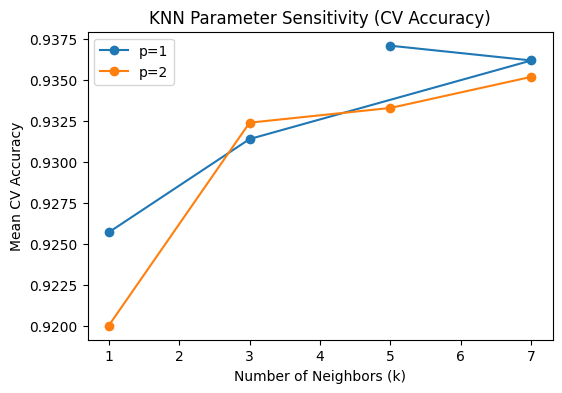

In [35]:
def knn_param_sensitivity(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

    param_grid = {'n_neighbors': k, 'p': p}
    knn = KNeighborsClassifier()

    gs = GridSearchCV(knn, param_grid=param_grid, cv=cvKFold, return_train_score=True)
    gs.fit(X_train, y_train)

    # Extract parameter combinations and corresponding average cross-validation accuracy
    # Convert cv_results_ to a pandas DataFrame and keep only the three columns we are interested in.
    results = pd.DataFrame(gs.cv_results_)[['param_n_neighbors', 'param_p', 'mean_test_score']]
    results['mean_test_score'] = results['mean_test_score'].round(4)
    # Sort by average cross-validation accuracy from high to low
    results = results.sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
    
    print("KNN Parameter Sensitivity (CV Accuracy):")
    print(results)

    # Save png
    plt.figure(figsize=(6, 4))
    for p_val in sorted(results['param_p'].unique()):
        subset = results[results['param_p'] == p_val]
        plt.plot(subset['param_n_neighbors'], subset['mean_test_score'],
                 marker='o', label=f"p={p_val}")

    plt.title("KNN Parameter Sensitivity (CV Accuracy)")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Mean CV Accuracy")
    plt.legend()
    
    plt.savefig("png/knn_param_sensitivity.png", dpi=500, bbox_inches="tight")
    print("Image saved")
    plt.show()

    return results

knn_results = knn_param_sensitivity(X, y)

#### Random Forest

RF Parameter Sensitivity (CV Accuracy):
   param_n_estimators  param_max_leaf_nodes  mean_test_score
0                  60                    12           0.9390
1                 100                    12           0.9390
2                  30                    12           0.9390
3                  60                     6           0.9371
4                  30                     6           0.9362
5                 100                     6           0.9362
6                  10                     6           0.9352
7                  10                    12           0.9343
Image saved


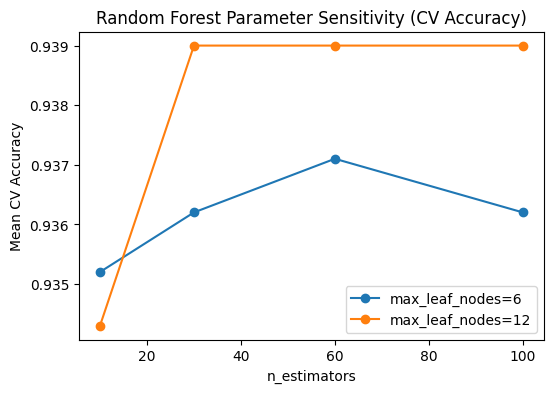

In [36]:
def rf_param_sensitivity(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

    param_grid = {'n_estimators': n_estimators, 'max_leaf_nodes': max_leaf_nodes}
    rf = RandomForestClassifier(criterion='entropy', max_features='sqrt', random_state=0)

    gs = GridSearchCV(rf, param_grid=param_grid, cv=cvKFold, return_train_score=True)
    gs.fit(X_train, y_train)

    # Extract parameter combinations and corresponding average cross-validation accuracy
    results = pd.DataFrame(gs.cv_results_)[['param_n_estimators', 'param_max_leaf_nodes', 'mean_test_score']]
    results['mean_test_score'] = results['mean_test_score'].round(4)
    # Sort by average cross-validation accuracy from high to low
    results = results.sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
    
    print("RF Parameter Sensitivity (CV Accuracy):")
    print(results)

    # Save png
    plt.figure(figsize=(6, 4))
    for leaf_val in sorted(results['param_max_leaf_nodes'].unique()):
        subset = results[results['param_max_leaf_nodes'] == leaf_val].sort_values(by='param_n_estimators')
        plt.plot(subset['param_n_estimators'], subset['mean_test_score'],
                 marker='o', label=f"max_leaf_nodes={leaf_val}")

    plt.title("Random Forest Parameter Sensitivity (CV Accuracy)")
    plt.xlabel("n_estimators")
    plt.ylabel("Mean CV Accuracy")
    plt.legend()
    
    plt.savefig("png/rf_param_sensitivity.png", dpi=500, bbox_inches="tight")
    print("Image saved")
    plt.show()

    return results
    
rf_results = rf_param_sensitivity(X, y)

# Thank you